# GLM Tutorial: French Motor Third-Party Liability Claims


#### Intro
This tutorial shows why and how to use Poisson, Gamma, and Tweedie GLMs on an insurance claims dataset using `quantcore.glm` It was inspired by, and closely mirrors, two other GLM tutorials that used this dataset:
1. An sklearn-learn tutorial, [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#pure-premium-modeling-via-a-product-model-vs-single-tweedieregressor), which was created for this (partially merged) [sklearn PR](https://github.com/scikit-learn/scikit-learn/pull/9405)
2. An R tutorial, [Case Study: French Motor Third-Party Liability Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764) with [R code](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims).


#### Background
Insurance claims are requests made by a policy holder to an insurance company for compensation in the event of a covered loss. When modeling these claims, the goal is often to estimate, per policy, the total claim amount per exposure unit. (i.e. number of claims $\times$ average amount per claim, per year). This amount is also referred to as the pure premium.

Two approaches for modeling this value are:
1. Modeling the total claim amount per exposure directly
2. Modeling number of claims and claim amount separately with a frequency and a severity model

In this tutorial, we demonstrate both approaches. We start with the second option as it shows how to use two different families/distributions (Poisson and Gamma) within a GLM on a single dataset. We then show the first approach using a single poison-gamma Tweedie regressor (i.e. a Tweedie with power $p \in (1,2)$)


#### Why not OLS?:

TLDR: The world is not Normal!

If we fit a GLM, the mean-variance relation of its family=distribution is key. Specifying a family is assuming its mean-variance relationship, which tells the GLM, how much a difference in predicted vs observed target values accounts to how much difference in (estimated parameters of) features. For example, the squared error&mdash;Normal distribution&mdash;is quite famous for being very sensitive to outliers, because it attributes much weight to large deviations. Simply put and slightly overstated: With a Normal distribution, a single large claim amount of only one young driver could result in a high prediction for all young drivers.

## Table of Contents <a class="anchor" id="toc"></a>
* [1. Load and Prepare Datasets from Openml.org](#1-load)
* [2. Frequency GLM - Poisson Distribution](#2-frequency)
* [3. Severity GLM - Gamma Distribution](#3-severity)
* [4. Combined GLM - Tweedie Distribution](#4-combined)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.model_selection import ShuffleSplit
from quantcore.glm import GeneralizedLinearRegressor
from quantcore.glm import TweedieDistribution

from load_transform import load_transform

## 1. Load and Prepare Datasets from Openml.org <a class="anchor" id="1-load"></a>
[back to table of contents](#toc)

First, we load in our dataset from openML and apply several transformations. In the interest of simplicity, we do not include the data loading and preparation code in this notebook. Below is a list of further resources if you wish to explore further: 
1. If you want to run the same code yourself, please see the helper functions here: **TODO – include link once in master**. 
2. For a detailed description of the data, see http://dutangc.free.fr/pub/RRepos/web/CASdatasets-index.html.
3. For an excellent exploratory data analysis, see the case study paper.

Some important notes about the dataset post-transformation:
- Total claim amounts are aggregated per policy
- For ClaimAmountCut, the claim amounts (pre-aggregation) were cut at 100,000 per single claim. We choose to use this amount rather than the raw ClaimAmount. (100,000 is the 0.9984 quantile but claims > 100,000 account for 25% of the overall claim amount)
- We aggregate the total claim amounts per policy
* ClaimNb is the total number of claims per policy, and ClaimNb_pos as the claim number with claim amount greater zero
* VehPower, VehAge, and DrivAge are clipped and/or digitized into bins so that they can be used as categoricals later on

In [2]:
df = load_transform()
with pd.option_context('display.max_rows', 10):
    display(df)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut,ClaimNb_pos
IDpol,,,,,,,,,,,,,,
1,1,0.10000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0,0
3,1,0.77000,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0,0
5,1,0.75000,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0,0
10,1,0.09000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0,0
11,1,0.84000,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,5,50,B12,Regular,3317,R93,0.0,0.0,0
6114327,0,0.00274,E,4,0,4,95,B12,Regular,9850,R11,0.0,0.0,0
6114328,0,0.00274,D,6,1,4,50,B12,Diesel,1323,R82,0.0,0.0,0


## 2. Frequency GLM - Poisson Distribution <a class="anchor" id="2-frequency"></a>
[back to Table of Contents](#toc)

We start with the first part of our two part GLM - modeling the frequency of claims using a Poisson regression. Below, we give some background on why the Poisson family makes the most sense in this context.

### 2.1 Why Poisson distributions?
We define:
- $z$: number of claims
- $w$: exposure (time in years under risk)
- $y = \frac{z}{w}$: claim frequency per year
- $X$: feature matrix

Note that both the number of claims $z$ and the exposure $w$ are additive. This way, the frequency behaves as expected, if we calculate averages: $\mathrm{mean}(y) = \frac{1}{\sum_i w_i}\sum_i w_i y_i = \frac{\sum_i z_i}{\sum_i w_i}$.

The number of claims $z$ is an integer, $z \in [0, 1, 2, 3, \ldots]$. Theoretically, a policy could have an arbitrarily large number of claims&mdash;very unlikely but possible. The simplest distribution for this range is a Poisson distribution $z \sim Poisson$. Instead of $z$, we will model the frequency $y$, which is still (scaled) Poisson distributed with variance inverse proportional to $w$, cf. [wikipedia:Reproductive_EDM](https://en.wikipedia.org/wiki/Exponential_dispersion_model#Reproductive). A very important property of the Poisson distribution is its mean-variance relation: The variance is proportional to the mean.

We summarize our assumptions for a Poisson-GLM model with log-link:
- target: $y \sim Poisson$
- mean: $\mathrm{E}[y] = \exp(X\beta)$
- variance: $\mathrm{Var}[y] = \frac{1}{w} \mathrm{E}[y]$

*Note*: We don't need $y$ to be Poisson distributed, for the purpose of estimating the expecation value. Just the mean-variance relationship should be approximately fulfilled: $\mathrm{Var}[y] \propto \frac{1}{w} \mathrm{E}[y]$.

To verify our assumptions, we start by plotting the observed frequencies and a fitted Poisson distributions (Poisson regression with intercept only).

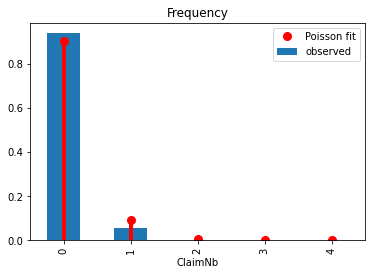

In [6]:
df_plot = (
    df.loc[:, ['ClaimNb', 'Exposure']].groupby('ClaimNb').sum()
    .assign(Frequency_Observed = lambda x: x.Exposure / df['Exposure'].sum())
)

df_plot['Frequency_Observed'].plot(kind = 'bar', label='observed')

mean = df['ClaimNb'].sum() / df['Exposure'].sum()
x = range(5)
plt.plot(x, scipy.stats.poisson.pmf(x, mean), 'ro', ms=8, mec='r', label='Poisson fit')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x)
plt.legend()
plt.title("Frequency");

Not too bad, visually.

Next, we want to check the mean-variance relationship of the Poisson distribution: $\mathrm{Var}[Y] = \frac{\mathrm{E}[Y]}{Exposure}$. To do so, we choose the feature `VehPower`, because we hope that the frequency $Y$ depends very much on it. We then plot empirical estimates of $\mathrm{Var}[Y]$ vs $\mathrm{E}[Y]/Exposure$ for every value of `VehPower`.

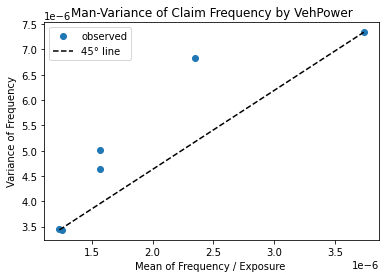

In [7]:
# Check mean-variance relationship for Poisson: Var[Y] = E[Y] / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]/Exposure
# Note: We group by VehPower in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    x_freq = x['Freq']
    x_expos = x['Exposure']
    n = x_freq.shape[0]
    names = {
        'Freq_mean': np.average(x_freq, weights=x_expos),
        'Freq_var': 1/(n-1) * np.sum((x_expos/np.sum(x_expos)) * (x_freq-np.average(x_freq, weights=x_expos))**2),
        'Exposure_sum': x_expos.sum()
    }
    return pd.Series(names, index=['Freq_mean', 'Freq_var', 'Exposure_sum'])

df_plot = df.assign(Freq = lambda x: x['ClaimNb']/x['Exposure']).groupby('VehPower').apply(my_agg)

plt.plot(df_plot['Freq_mean']/df_plot['Exposure_sum'], df_plot['Freq_var'], '.',
         markersize=12, label='observed')

plt.plot([(df_plot['Freq_mean']/df_plot['Exposure_sum']).min(),
          (df_plot['Freq_mean']/df_plot['Exposure_sum']).max()],
         [df_plot['Freq_var'].min(), df_plot['Freq_var'].max()],
         'k--', label='45° line')

plt.xlabel('Mean of Frequency / Exposure ')
plt.ylabel('Variance of Frequency')
plt.title('Man-Variance of Claim Frequency by VehPower');
plt.legend()
plt.show()

This is a strong confirmation for the use of a Poisson when fitting!

*Hints*:
- If Y were normal distributed, one should see a horizontal line, because for a Normal: Var[Y] ~ constant/Exposure.
- The 45° line is not even necessary, any straight line through the origin would be enough for simple reasons:
    1. A quasi-Poisson distribution has $Var[Y] = \phi * E[Y]/w$ for some $\phi$.
    2. $\phi$ does not influence the estimation/fitting of E[Y] (thanks @[ExponentialDispersionFamily](https://en.wikipedia.org/wiki/Exponential_dispersion_model)).

### 2.2 Train and Test Frequency GLM


We now start fitting our model. We use claim number with positive claim amount 'ClaimNb_pos' and we devide the dataset into training set and test set with a 9:1 random split. 

Also, notice that we do not one hot encode our columns. Rather, we take advantage of `quantcore.glm`'s integration with `quantcore.matrix`, which allows us to pass in categorical columns directly! `quantcore.matrix` will handle the encoding for us and even includes a handful of helpful matrix operation optimizations. We use the `Categorizer` from [dask_ml](https://ml.dask.org/modules/generated/dask_ml.preprocessing.Categorizer.html) to set our categorical columns as categorical dtypes.

In [8]:
z = df['ClaimNb_pos'].values
weight = df['Exposure'].values
y = z / weight # claims frequency

ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train, test = next(ss.split(y))

categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_p = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_p = glm_categorizer.fit_transform(df[predictors].iloc[test])
y_train_p, y_test_p = y[train], y[test] 
w_train_p, w_test_p = weight[train], weight[test]
z_train_p, z_test_p = z[train], z[test]

Now, we define our GLM using the `GeneralizedLinearRegressor` class from `quantcore.glm`.
- `family='poisson'`: creates a Poisson regressor
- `alpha_search=True`: tells the GLM to search along the regularization path for the best alpha
- `l1_ratio = 1` tells the GLM to only use l1 penalty (not l2). `l1_ratio` is the elastic net mixing parameter. For ``l1_ratio = 0``, the penalty is an L2 penalty. ``For l1_ratio = 1``, it is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2.

See the `GeneralizedLinearRegressor` class documentation for more details (TODO: include documentation link once up).

*Note*: `quantcore.glm` also supported a cross validation model GeneralizedLinearRegressorCV. However, like most cross validation models, it is inevitably slower, so we don't demonstrate it in this tutorial.

In [ ]:
f_glm1 = GeneralizedLinearRegressor(family='poisson', alpha_search=True, l1_ratio=1, fit_intercept=True)

f_glm1.fit(
    X_train_p,
    y_train_p,
    sample_weight=w_train_p
);

pd.DataFrame({'coefficient': np.concatenate(([f_glm1.intercept_], f_glm1.coef_))},
             index=['intercept'] + f_glm1.feature_names_).T

To measure our model's test and train performance, we use the deviance function for the Poisson family. We can get the total deviance function directly from `quantcore.glm`'s distribution classes and divide it by the sum of our sample weight. 

*Note*: a Poisson distribution is equivlane to a Tweedie distribution with power = 1. 

In [ ]:
PoissonDist = TweedieDistribution(1)
print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(y_train_p, f_glm1.predict(X_train_p), weights=w_train_p)/np.sum(w_train_p)
))

print('test loss f_glm1: {}'.format(
      PoissonDist.deviance(y_test_p, f_glm1.predict(X_test_p), weights=w_test_p)/np.sum(w_test_p)))

A GLM with canonical link function (Normal - identity, Poisson - log, Gamma - 1/x, Binomial - logit) with an intercept term has the so called **balance property**. Neglecting small deviations by the opimizer used for fitting, the results fulfil on the training sample:
$$\sum_{i \in training} w_i y_i = \sum_{i \in training} w_i \hat{\mu}_i$$
Summing up the predictions $\hat{\mu}_i$ yields exaclty the observations $y_i$. 

In [ ]:
# balance property of GLM with canonical link, like log-link for Poisson:
z_train_p.sum(), (f_glm1.predict(X_train_p) * w_train_p).sum()

In [ ]:
# for Poisson deviance, note that the following are equivalent (with freq = count/weight)
# dev(observed count, predicted count) ~ dev(observed freq, predicted freq, sample_weight=weight)
print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(y_train_p, f_glm1.predict(X_train_p), weights=w_train_p)/len(train)))

print('training loss f_glm1: {}'.format(
    PoissonDist.deviance(z_train_p, f_glm1.predict(X_train_p) * w_train_p)/len(train)))

print('testing loss f_glm1:  {}'.format(
    PoissonDist.deviance(z_test_p, f_glm1.predict(X_test_p) * w_test_p)/len(test)))

# Compare to test loss of Mean model
print('testing loss Mean:    {}'.format(
    PoissonDist.deviance(z_test_p,
                     np.average(y_train_p, weights=w_train_p)*w_test_p)/len(test)))

## 3. Severity GLM -  Gamma Distribution <a class="anchor" id="3-severity"></a>
[back to Table of Contents](#toc)

Now, we fit a GLM model for the severity with the same features as the freq model.
The severity $y$ is the average claim size.
We define:
- $z$: total claim amount, single claims cut at 100,000
- $w$: number of claims (with positive claim amount!)
- $y = \frac{z}{w}$: severity

### 3.1 Why Gamma distributions
The severity $y$ is a positive, real number, $y \in (0, \infty)$. Theoretically, especially for liability claims, one could have arbitrary large numbers&mdash;very unlikely but possible. A very simple distribution for this range is an Exponential distribution, or its generalization, a Gamma distribution $y \sim Gamma$. In the insurance industry, it is well known that the severity might be skewed and have heavy tails, i.e. a few very large losses, as does our dataset. That's why we only analyse the claim amount cut at 100'000.

A Gamma distribution has mean-variance relation $\mathrm{Var}[Y] = \frac{\phi}{w} \mathrm{E}[Y]^2$. Note that the dispersion $\phi$ does not influence the estimation of $E[\mu]$.

In [ ]:
df_plot = (
    df.loc[:, ['ClaimAmountCut', 'ClaimNb_pos']]
    .query('ClaimNb_pos > 0')
    .assign(Severity_Observed = lambda x: x['ClaimAmountCut'] / df['ClaimNb_pos'])
)

df_plot['Severity_Observed'].plot.hist(bins=400, density=True, label='Observed', )

x = np.linspace(0, 1e5, num=400)
plt.plot(x,
         scipy.stats.gamma.pdf(x, *scipy.stats.gamma.fit(df_plot['Severity_Observed'], floc=0)),
         'r-', label='fitted Gamma')
plt.legend()
plt.title("Severity");
plt.xlim(left=0, right = 1e4);
#plt.xticks(x);

In [ ]:
# Check mean-variance relationship for Gamma: Var[Y] = E[Y]^2 / Exposure
# Estimate Var[Y] and E[Y]
# Plot estimates Var[Y] vs E[Y]^s/Exposure
# Note: We group by VehPower and BonusMalus in order to have different E[Y].

def my_agg(x):
    """See https://stackoverflow.com/q/44635626"""
    x_sev = x['Sev']
    x_cnb = x['ClaimNb_pos']
    n = x_sev.shape[0]
    names = {
        'Sev_mean': np.average(x_sev, weights=x_cnb),
        'Sev_var': 1/(n-1) * np.sum((x_cnb/np.sum(x_cnb)) * (x_sev-np.average(x_sev, weights=x_cnb))**2),
        'ClaimNb_pos_sum': x_cnb.sum()
    }
    return pd.Series(names, index=['Sev_mean', 'Sev_var', 'ClaimNb_pos_sum'])

for col in ['VehPower', 'BonusMalus']:
    claims = df.groupby(col)['ClaimNb_pos'].sum()
    df_plot = (df.loc[df[col].isin(claims[claims >= 4].index), :]
               .query('ClaimNb_pos > 0')
               .assign(Sev = lambda x: x['ClaimAmountCut']/x['ClaimNb_pos'])
               .groupby(col)
               .apply(my_agg)
              )

    plt.plot(df_plot['Sev_mean'], df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'], '.',
             markersize=12, label='observed')

    # fit: mean**p/claims
    p = optimize.curve_fit(lambda x, p: np.power(x, p),
                           df_plot['Sev_mean'].values,
                           df_plot['Sev_var'] * df_plot['ClaimNb_pos_sum'],
                           p0 = [2])[0][0]
    df_fit = pd.DataFrame({'x': df_plot['Sev_mean'],
                           'y': np.power(df_plot['Sev_mean'], p)})
    df_fit = df_fit.sort_values('x')

    plt.plot(df_fit.x, df_fit.y,
             'k--', label='fit: Mean**{}'.format(p))
    plt.xlabel('Mean of Severity ')
    plt.ylabel('Variance of Severity * ClaimNb_pos')
    plt.legend()
    plt.title('Man-Variance of Claim Severity by {}'.format(col))
    plt.show()

This is good empirical confirmation to use the Gamma.

*Note*: The data seems to be slightly heavier tailed than a Gamma, because estimated p > 2 (it is 2.27 or 2.20). The second plot with BonusMalus might even suggest 2 different regions, on region from 0 to 1'800 and another from 1'800 upwards.

*Hint*: If Y were normal distributed, one should see a horizontal line, because $Var[Y] \sim constant/Exposure$
       and the fit should give $p \approx 0$.

### 3.2 Severity GLM with Train and Test Data
We fit a GLM model for the severity with the same features as the freq model. We use the same categorizer as before. 

*Note*:
- We filter out ClaimAmount == 0 as the Gamma distribution as support on $(0, \infty)$ not $[0, \infty)$
- We use ClaimNb_pos as sample weights.
- We use the same split in train and test data such that we can predict the final claim amount on the test set.

In [ ]:
idx = df['ClaimAmountCut'].values > 0

z = df['ClaimAmountCut'].values
weight = df['ClaimNb_pos'].values
# y = claims severity
y = np.zeros_like(z)  # zeros will never be used
y[idx] = z[idx] / weight[idx]

# we also need to represent train and test as boolean indices
itrain = np.zeros(y.shape, dtype='bool')
itest = np.zeros(y.shape, dtype='bool')
itrain[train] = True
itest[test] = True
# simplify life
itrain = idx & itrain
itest = idx & itest

X_train_g = glm_categorizer.fit_transform(df[predictors].iloc[itrain])
X_test_g = glm_categorizer.fit_transform(df[predictors].iloc[itest])
y_train_g, y_test_g = y[itrain], y[itest] 
w_train_g, w_test_g = weight[itrain], weight[itest]
z_train_g, z_test_g = z[itrain], z[itest]

We fit our model with the same parameters before, but of course, this time we use `family=gamma`.

In [ ]:
s_glm1 = GeneralizedLinearRegressor(family='gamma', alpha_search=True, l1_ratio=1, fit_intercept=True)
s_glm1.fit(X_train_g, y_train_g, sample_weight=weight[itrain])

pd.DataFrame({'coefficient': np.concatenate(([s_glm1.intercept_], s_glm1.coef_))},
             index=['intercept'] + s_glm1.feature_names_).T

Again, we measure peformance with the deviance of the distribution.

*Note*: a Gamma distribution is equivlane to a Tweedie distribution with power = 2.

In [ ]:
GammaDist = TweedieDistribution(2)
print('training loss s_glm1: {}'.format(
    GammaDist.deviance(y_train_g, s_glm1.predict(X_train_g), weights=w_train_g)/np.sum(w_train_g)))

print('testing loss s_glm1:  {}'.format(
    GammaDist.deviance(y_test_g, s_glm1.predict(X_test_g), weights=w_test_g)/np.sum(w_test_g)))

print('testing loss Mean:    {}'.format(
    GammaDist.deviance(y_test_g,
                   np.average(z_train_g, weights=w_train_g)*np.ones_like(z_test_g),
                   weights=w_test_g)/np.sum(w_test_g)))


### 3.3 Combined Frequency and Severity Results

We put together the prediction of frequency and severity to get the predictions of the total claim amount per policy.

In [ ]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * f_glm1.predict(X_train_p) * s_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * f_glm1.predict(X_test_p) * s_glm1.predict(X_test_p)))
     )

## 4. Combined GLM - Tweedie Distribution <a class="anchor" id="4-combined"></a>
[back to Table of Contents](#toc)

Finally, to demonstrate an alternate approach to the combined frequency severity model, we show how we can model pure premium directly using a Tweedie regressor. Any Tweedie distribution with power $p\in(1,2)$ is known as [compound Poisson Gamma distribution](https://en.wikipedia.org/wiki/Compound_Poisson_distribution#Compound_Poisson_Gamma_distribution)

In [ ]:
weight = df['Exposure'].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]

X_train_t = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_t = glm_categorizer.fit_transform(df[predictors].iloc[test])
y_train_t, y_test_t = y.iloc[train], y.iloc[test] 
w_train_t, w_test_t = weight[train], weight[test]

If we really wanted to optimize the model, we would ideally select the power parameter with a grid-search that minimizes the negative log-likelihood of the Tweedie model. However, for now, we just arbitrarily select 1.5 as our power.

*Note*: notice how we pass the distibution in directly for the family parameter. While `quantcore.glm` supports strings for the family parameter, if you are using a common distribution (e.g. like Poisson and Gamma seen above), you can also pass in a quantcore.glm distribution directly.

In [ ]:
TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, alpha_search=True, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame({'coefficient': np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
             index=['intercept'] + t_glm1.feature_names_).T

Again, we use the distribution's deviance to measure model performance

In [ ]:
print('training loss s_glm1: {}'.format(
    TweedieDist.deviance(y_train_t, t_glm1.predict(X_train_t), weights=w_train_t)/np.sum(w_train_t)))

print('testing loss s_glm1:  {}'.format(
    TweedieDist.deviance(y_test_t, t_glm1.predict(X_test_t), weights=w_test_t)/np.sum(w_test_t)))

Finally, we again show the total predicted vs. true claim amount on the training and test set

In [ ]:
#Put together freq * sev together
print("Total claim amount on train set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[train].sum(),
            np.sum(df['Exposure'].values[train] * t_glm1.predict(X_train_p)))
     )

print("Total claim amount on test set, observed = {}, predicted = {}".
     format(df['ClaimAmountCut'].values[test].sum(),
            np.sum(df['Exposure'].values[test] * t_glm1.predict(X_test_p)))
     )

Ultimately, the combined frequency severity model performed a bit better, but both approaches prove to be effective.